In [1]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' 
import networkx as nx
import itertools
import pandas as pd
import numpy as np
from stellargraph import StellarGraph
from tensorflow import keras
import tensorflow as tf

import stellargraph as sg
from stellargraph.data import EdgeSplitter
from stellargraph.mapper import HinSAGELinkGenerator

import matplotlib.pyplot as plt
from tensorflow.keras import mixed_precision

In [2]:
g = nx.read_graphml("./graph/test_graph.gml")
species_features_dummy = pd.read_csv("./data/species_features.csv.gz", index_col=0)
molecule_features_dummy = pd.read_csv("./data/molecule_features.csv.gz", index_col=0).astype("int8")
df_agg = pd.read_csv("./data/lotus_agg_test.csv.gz", index_col=0)

In [3]:
rdkit = pd.read_csv("./data/mol_dummy_rdkit.csv.gz", index_col=0).astype('int8')
molecule_features_dummy = molecule_features_dummy.merge(rdkit,
                                                        left_index=True,
                                                        right_index=True)

In [4]:
species_feat = species_features_dummy[species_features_dummy.index.isin(df_agg.organism_name)]
molecule_feat = molecule_features_dummy[molecule_features_dummy.index.isin(df_agg.structure_smiles_2D)]

In [5]:
df_agg_train = pd.read_csv("./data/lotus_agg_train.csv.gz", index_col=0)

In [6]:
species_unique_to_test_set = df_agg[~df_agg.organism_name.isin(df_agg_train.organism_name)]
molecules_unique_to_test_set = df_agg[~df_agg.structure_smiles_2D.isin(df_agg_train.structure_smiles_2D)]

In [7]:
g_train = nx.read_graphml("./graph/train_graph.gml")

In [8]:
g = nx.create_empty_copy(g)
g_merged = nx.compose(g_train, g)

In [9]:
G = StellarGraph.from_networkx(g_merged,
                               node_features={'species': species_features_dummy,
                                              'molecule':molecule_features_dummy})

In [10]:
print(G.info())
G.check_graph_for_ml()

StellarDiGraph: Directed multigraph
 Nodes: 184194, Edges: 608638

 Node types:
  molecule: [147747]
    Features: float32 vector, length 1051
    Edge types: molecule-present_in->species
  species: [36447]
    Features: float32 vector, length 69
    Edge types: species-has->molecule

 Edge types:
    species-has->molecule: [304319]
        Weights: all 1 (default)
        Features: none
    molecule-present_in->species: [304319]
        Weights: all 1 (default)
        Features: none


In [11]:
model = tf.keras.models.load_model("./model/gbif_batch_128_layer_1024_s_to_m", compile=True)

In [12]:
species_unique_to_test_set = species_unique_to_test_set[['organism_name', 'structure_smiles_2D']].to_numpy()

In [13]:
test_flow = HinSAGELinkGenerator(G,
                                 batch_size=128,
                                num_samples=[3,1],
                                head_node_types=["species", "molecule"]).flow(species_unique_to_test_set,
                                                                              np.ones(len(species_unique_to_test_set)).reshape(-1,1))

In [14]:
def predict(model, flow, iterations=10):
    predictions = []
    for _ in range(iterations):
        predictions.append(model.predict(flow, workers=-1).flatten())

    return np.mean(predictions, axis=0)

In [15]:
result = predict(model, test_flow)

24/24 [==============================] - 1s 25ms/step


Text(0.5, 1.0, 'Test on unknown SPECIES but known MOLECULES')

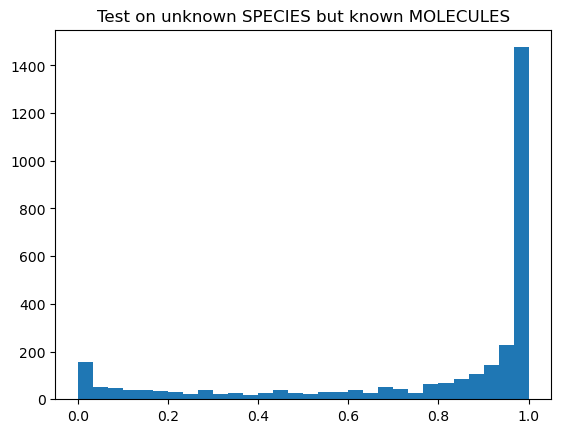

In [16]:
plt.hist(result, bins=30)
plt.title("Test on unknown SPECIES but known MOLECULES")

In [17]:
sum(result>0.5)/len(result)

0.7994766110565914

In [18]:
molecules_unique_to_test_set = molecules_unique_to_test_set[['organism_name', 'structure_smiles_2D']].to_numpy()

In [19]:
test_flow_mol = HinSAGELinkGenerator(G,
                                 batch_size=128,
                                num_samples=[3,1],
                                head_node_types=["species", "molecule"]).flow(molecules_unique_to_test_set,
                                                                              np.ones(len(molecules_unique_to_test_set)).reshape(-1,1))

In [20]:
out_mol = predict(model, test_flow_mol)

274/274 [==============================] - 6s 22ms/step


Text(0.5, 1.0, 'Test on unknown MOLECULES but known SPECIES')

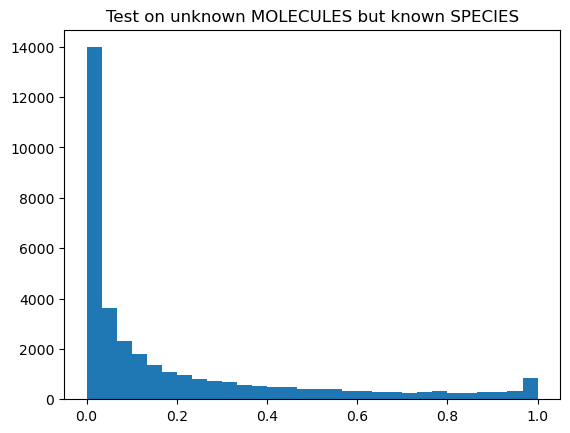

In [21]:
plt.hist(out_mol, bins=30)
plt.title("Test on unknown MOLECULES but known SPECIES")

In [22]:
sum(out_mol>0.5)/len(out_mol)

0.14749599817059228

In [23]:
molecules_unique_to_test_set

array([['Panax ginseng',
        'CC(C)=CCCC(C)(OC1OCC(O)C(O)C1O)C1CCC2(C)C1C(O)CC1C3(C)CCC(O)C(C)(C)C3C(OC3OC(CO)C(O)C(O)C3O)CC12C'],
       ['Brickellia diffusa',
        'CC=C(C)C(=O)OC1CC2(C)C3CC4(OC(=O)C=C4C)OC(O)C3=CCC2C(C)(C)C1OC(=O)C(C)=CC'],
       ['Frasera speciosa', 'COc1cccc2c(=O)c3c(O)cc(O)c(OC)c3oc12'],
       ...,
       ['Nocardia',
        'CCCCCCCCCCCCCC=CC(=O)N(O)CCCCCNC(=O)CCC(=O)N(O)CCCCCNC(=O)C1COC(c2ccccc2O)=N1'],
       ['Penicillium', 'Cc1c(O)c(C(=O)O)c(O)c2c1C(C)C(C)OC2'],
       ['Walsura yunnanensis',
        'CC1(C)C(=O)C=CC2(C)C1=C(O)C(=O)C1(C)C2CCC2(C)C(C3=CC(=O)OC3O)CC3OC321']],
      dtype=object)

In [24]:
out_mol

array([0.37528625, 0.24599166, 0.17932765, ..., 0.05946297, 0.02786124,
       0.02618088], dtype=float32)

## Discussion 

As expected, we got the opposite result as before. 

We should then either mix these models or restart with an other library because Stellargraph only accepts one edge type for prediction. This is very interesting though and it is still very cool to see that it could work in some cases. 